#### Brief idea behind the assignment, per Analytics Vidhya assignment documentation - 

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

#### Problem Statement - Brief Understanding of the problem - 

We would have to predict the trip duration for the taxi rides. Now, given, if the trip duration is predicted (fairly) accurately, then ride allocator system can allocate the nearby taxis to a ride requestor efficiently, even before ending of the current rides for the taxis. Total wait times for the requestor can be further deduced by the summation of remaining time for the current trip to end, and the (estimated) time taken for the taxis to reach the requestor, based upon the geo co-ordinates of the trip-end location. As a side note, with correct trip duration predictor in place, care can further be taken to optimally utilize the fleet, by reducing the unutilized cases.

#### Gathering the data - 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


We are already supplied with the required data, hence scope of filtering and getting data from divergent resources, based upon the problem statement/base hypothesis is somewhat limited here. And based upon the data obtained from the sheet above, its clearly observed that we are able to read data from the sheet and the data looks to be well distributed across the columns. No visible issues regarding presence of multi-column data in a single column is observed (so there's no special column separators been used in the sheet).

#### Data Exploration - Missing value investigations - 

In [2]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

We investigated for the missing values across all the columns in the data frame. As in the further steps, we might be required to work on categorical data, any missing values on those might require additional handlings (like should we create a new category for the missing cases, or the missing cases are more analogous to a specific category, so that we can club etc). Additionally, presence of missing values in numeric discrete or continuous cases can make the model building to fail, hence normally we impute or drop those numerical cases before model building steps. Here we don't have any missing values, hence we should be all good.

#### Feature Engineering I - Modifying/Adding Features - 

As first step of feature engineering, we are handling all the datetime related features, modifying and creating features out of it. Along with those, store and forward. and vendor id are converted onto categories.

In [3]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [4]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df['pickup_datetime'] = df['pickup_datetime'].dt.round('15min')
df['dropoff_datetime'] = df['dropoff_datetime'].dt.round('15min')


df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['pickup_month'] = df['pickup_datetime'].dt.month_name()
df['pickup_date'] = df['pickup_datetime'].dt.day
df['pickup_time'] = df['pickup_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day_name()
df['dropoff_month'] = df['dropoff_datetime'].dt.month_name()
df['dropoff_date'] = df['dropoff_datetime'].dt.day
df['dropff_time'] = df['dropoff_datetime'].dt.hour

df.drop(['pickup_datetime', 'dropoff_datetime', 'id'], inplace = True, axis = 1)

df['pickup_month'] = df['pickup_month'].astype('category')
df['pickup_day'] = df['pickup_day'].astype('category')
df['dropoff_month'] = df['dropoff_month'].astype('category')
df['dropoff_day'] = df['dropoff_day'].astype('category')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
df['vendor_id'] = df['vendor_id'].astype('category')
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_date,pickup_time,dropoff_day,dropoff_month,dropoff_date,dropff_time
0,2,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,February,29,16,Monday,February,29,16
1,1,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,March,11,23,Saturday,March,12,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,February,21,18,Sunday,February,21,18
3,2,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,January,5,9,Tuesday,January,5,10
4,1,1,-74.017120,40.708469,-73.988182,40.740631,N,848,Wednesday,February,17,6,Wednesday,February,17,7


All the datetime features are converted from string to datetime. And later individual datetime characteristics are extracted from it, for example, we extracted day name, month name, day and hour. This is done as we could then determine the effectivity of individual datetime parts in predicting the target. Also, complete datetime itself has never been a good predictor, as differentiating across variables and/or finding patterns from it would be difficult and time-consuming for the models. Id column is dropped, as otherwise it would increase unnecessary variability of the data frame for the model. Other than uniquely determining the records, it won't be having any other value.

In [5]:
df.dtypes

vendor_id             category
passenger_count          int64
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_day            category
pickup_month          category
pickup_date              int64
pickup_time              int64
dropoff_day           category
dropoff_month         category
dropoff_date             int64
dropff_time              int64
dtype: object

In [6]:
df.corr()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_time,dropoff_date,dropff_time
passenger_count,1.000000,0.001163,-0.004696,-0.000027,-0.003944,0.013022,0.001822,0.009499,0.001967,0.008399
pickup_longitude,0.001163,1.000000,0.047635,0.780647,0.118473,0.035447,-0.001426,0.010640,-0.001514,0.010928
pickup_latitude,-0.004696,0.047635,1.000000,0.119970,0.479352,-0.038163,-0.006356,0.015387,-0.006287,0.022157
dropoff_longitude,-0.000027,0.780647,0.119970,1.000000,0.149598,0.020664,-0.000284,-0.022493,-0.000357,-0.023784
dropoff_latitude,-0.003944,0.118473,0.479352,0.149598,1.000000,-0.028283,-0.006095,0.016838,-0.006006,0.020881
trip_duration,0.013022,0.035447,-0.038163,0.020664,-0.028283,1.000000,0.000993,0.003094,0.001686,0.003585
pickup_date,0.001822,-0.001426,-0.006356,-0.000284,-0.006095,0.000993,1.000000,-0.001788,0.997817,-0.001820
pickup_time,0.009499,0.010640,0.015387,-0.022493,0.016838,0.003094,-0.001788,1.000000,-0.001656,0.932332
dropoff_date,0.001967,-0.001514,-0.006287,-0.000357,-0.006006,0.001686,0.997817,-0.001656,1.000000,-0.002026
dropff_time,0.008399,0.010928,0.022157,-0.023784,0.020881,0.003585,-0.001820,0.932332,-0.002026,1.000000


Before we go any further, we just checked the correlation matrix amongst features, more specifically amongst the probable input features. We see that pickup_longitude and dropoff_longitude (0.78), pickup_latitude and dropoff_latitude (0.48), pickup_date and dropoff_date (0.99), pickup_time and dropoff_time (0.93) have high correlations. We are keeping the pickup ones and let's drop the dropoff ones. As otherwise the predictions made by the model won't be trustworthy and it will varry more than what we expect.

In [7]:
df = df.drop(['dropoff_date', 'dropff_time', 
                      'dropoff_latitude', 'dropoff_longitude'], axis = 1)
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_date,pickup_time,dropoff_day,dropoff_month
0,2,1,-73.953918,40.778873,N,400,Monday,February,29,16,Monday,February
1,1,2,-73.988312,40.731743,N,1100,Friday,March,11,23,Saturday,March
2,2,2,-73.997314,40.721458,N,1635,Sunday,February,21,18,Sunday,February
3,2,6,-73.961670,40.759720,N,1141,Tuesday,January,5,9,Tuesday,January
4,1,1,-74.017120,40.708469,N,848,Wednesday,February,17,6,Wednesday,February


#### Feature Engineering II - Encoding Categorical Columns -

In [8]:
df = pd.get_dummies(df, columns=['store_and_fwd_flag', 'pickup_day', 'pickup_month', 'dropoff_day', 'dropoff_month'])
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,trip_duration,pickup_date,pickup_time,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_day_Friday,...,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,dropoff_month_April,dropoff_month_February,dropoff_month_January,dropoff_month_July,dropoff_month_June,dropoff_month_March,dropoff_month_May
0,2,1,-73.953918,40.778873,400,29,16,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,2,-73.988312,40.731743,1100,11,23,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,2,-73.997314,40.721458,1635,21,18,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,6,-73.961670,40.759720,1141,5,9,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,-74.017120,40.708469,848,17,6,1,0,0,...,0,0,1,0,1,0,0,0,0,0


We are encoding (one hot encoding) the categorical columns as models won't work on string data. We have done this keeping in mind that, we have a limited number of categories in each column, for example store and forward can have two values, that is Y and N, or pickup/dropoff day can have any day within a range of seven etc.

#### Model Building - Reusable Function - 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing

def create_lr_model(X, Y, test_size=0.20, random_state=42, nl = 30):
   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    reg = LinearRegression(normalize=True).fit(X_train, Y_train)

    Y_predicted = reg.predict(X_train)
    mae = metrics.mean_absolute_error(Y_train, Y_predicted)

    print('Training MAE is {}'.format(mae))

    Y_predicted = reg.predict(X_test)
    mae = metrics.mean_absolute_error(Y_test, Y_predicted)

    print('Testing MAE is {}'.format(mae))
    
    coefficients = pd.DataFrame({
        'Variable': X_test.columns,
        'Coefficient': reg.coef_
    })
    
    return coefficients.nlargest(nl, 'Coefficient')
    


We have created a function which probably we would be using multiple times to create and evaluate or optimize our linear regression models subsequently. Test Size is specified as 20 % as default if not passed to the function. And random state is mentioned so that our predictions are somewhat repeatable.

#### Simple model with all input features - 

In [12]:
X = df.drop('trip_duration', axis = 1)
Y = df['trip_duration']
coeffs = create_lr_model(X, Y)
coeffs

Training MAE is 609.8583546002533
Testing MAE is 615.5384944983375


,Variable,Coefficient
7,store_and_fwd_flag_Y,2.122072e+15
6,store_and_fwd_flag_N,2.122072e+15
23,dropoff_day_Monday,3.419139e+14
25,dropoff_day_Sunday,3.419139e+14
27,dropoff_day_Tuesday,3.419139e+14
24,dropoff_day_Saturday,3.419139e+14
28,dropoff_day_Wednesday,3.419139e+14
22,dropoff_day_Friday,3.419139e+14
26,dropoff_day_Thursday,3.419139e+14
2,pickup_longitude,1.715893e+03


Model performance is more or less consistent between train and test sets. But we used a lot of input features and haven't specifically seen the relative importance of the input features in determining the target. In next few cases, we would concentrate on how we can optimize our model. 
Later we made some changes to the function, along with calculating model training and testing errors, it returns the weightage of the features in descending order. Next we would try if we can use a sub set of features (depending upon the weightage) and get the same or better accuracy.

#### Effort to obtain model with similar/better accuracy with subset of features - 

In [13]:
i = 1
while i < len(coeff):
    X_subset = X.copy()
    print('Evaluation with top {} features - '.format(i))
    create_lr_model(X_subset[coeffs.Variable[:i]], Y)
    print('---------------------------------------------')
    i = i + 1

Evaluation with top 1 features - 
Training MAE is 617.1646256217065
Testing MAE is 622.7859181142228
---------------------------------------------
Evaluation with top 2 features - 
Training MAE is 617.1675961124813
Testing MAE is 622.7888826997566
---------------------------------------------
Evaluation with top 3 features - 
Training MAE is 617.1741876436481
Testing MAE is 622.7954606999623
---------------------------------------------
Evaluation with top 4 features - 
Training MAE is 616.7042782287298
Testing MAE is 622.3449105337127
---------------------------------------------
Evaluation with top 5 features - 
Training MAE is 616.7761728799209
Testing MAE is 622.4258642409077
---------------------------------------------
Evaluation with top 6 features - 
Training MAE is 616.1903409334363
Testing MAE is 621.8325172248312
---------------------------------------------
Evaluation with top 7 features - 
Training MAE is 616.2062778405264
Testing MAE is 621.843266890618
------------------

In the above case, we tried with varying combinations of input features and tried to see the performance. We see that, with 18 features, we have started getting (so far) lowest errors and later we see that there's a tendency for errors to rise while we keeping on adding features at the input vector, this is probably due to overfitting.

In [18]:
df_toSave = pd.concat((X.copy()[coeffs.Variable[:18]], Y), axis = 1)
df_toSave.head()

,store_and_fwd_flag_Y,store_and_fwd_flag_N,dropoff_day_Monday,dropoff_day_Sunday,dropoff_day_Tuesday,dropoff_day_Saturday,dropoff_day_Wednesday,dropoff_day_Friday,dropoff_day_Thursday,pickup_longitude,vendor_id,passenger_count,pickup_time,pickup_date,pickup_latitude,pickup_month_January,pickup_month_February,pickup_month_March,trip_duration
0,0,1,1,0,0,0,0,0,0,-73.953918,2,1,16,29,40.778873,0,1,0,400
1,0,1,0,0,0,1,0,0,0,-73.988312,1,2,23,11,40.731743,0,0,1,1100
2,0,1,0,1,0,0,0,0,0,-73.997314,2,2,18,21,40.721458,0,1,0,1635
3,0,1,0,0,1,0,0,0,0,-73.961670,2,6,9,5,40.759720,1,0,0,1141
4,0,1,0,0,0,0,1,0,0,-74.017120,1,1,6,17,40.708469,0,1,0,848


In [19]:
df_toSave.shape

(729322, 19)

In [20]:
df_toSave.to_csv('taxi-trip-reduced-features.csv', index = False)
df = pd.read_csv('taxi-trip-reduced-features.csv')
df.head()

,store_and_fwd_flag_Y,store_and_fwd_flag_N,dropoff_day_Monday,dropoff_day_Sunday,dropoff_day_Tuesday,dropoff_day_Saturday,dropoff_day_Wednesday,dropoff_day_Friday,dropoff_day_Thursday,pickup_longitude,vendor_id,passenger_count,pickup_time,pickup_date,pickup_latitude,pickup_month_January,pickup_month_February,pickup_month_March,trip_duration
0,0,1,1,0,0,0,0,0,0,-73.953918,2,1,16,29,40.778873,0,1,0,400
1,0,1,0,0,0,1,0,0,0,-73.988312,1,2,23,11,40.731743,0,0,1,1100
2,0,1,0,1,0,0,0,0,0,-73.997314,2,2,18,21,40.721458,0,1,0,1635
3,0,1,0,0,1,0,0,0,0,-73.961670,2,6,9,5,40.759720,1,0,0,1141
4,0,1,0,0,0,0,1,0,0,-74.017120,1,1,6,17,40.708469,0,1,0,848


In [21]:
df.shape

(729322, 19)

As this is our (so far) optimized model, so we have saved this subset of features in a csv file and re-loaded into a frame. This way we would now be concentrating on further optimization on it and we won't be required to run the previous steps again and again.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing

#### Our Optimized model (so far) & Fitted vs Predicted Plot - 

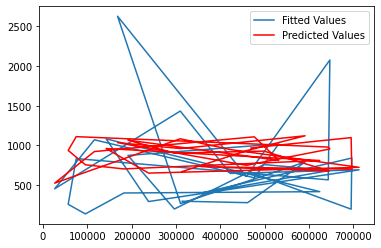

In [31]:
X = df.drop('trip_duration', axis = 1)
Y = df['trip_duration']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
Y_predicted = reg.predict(X_test)

residuals = pd.DataFrame({
    'fitted_values': Y_test,
    'predicted_values': Y_predicted
})
plt.plot(residuals['fitted_values'][:30], label='Fitted Values')
plt.plot(residuals['predicted_values'][:30], label='Predicted Values', color = 'r')
plt.legend()
# residuals['residuals_prct'] = ((residuals['fitted_values'] - residuals['predicted_values']) / residuals['fitted_values']) * 100
# residuals['residuals_prct'].describe()

Looks like our model didn't try to overfit the training data, rather a more generalized trend (to understand the pattern) is observed from the model performance. From the plot above, we suspect that, there can be some outliers present/unusual longer trips thats probably having some impact on how our model is behaving. Next, we would explore in this line.

In [37]:
from scipy import stats
(len(df[(np.abs(stats.zscore(df['trip_duration'])) >= 3)])/df.shape[0]) * 100

0.13985592097866237

This means, we have definite outliers at trip_duration feature, and that is significantly different than the rest of the data. zscore is an indication for that. Unfortunately, we have such data in around 14 % of the total number of records. So, that means, if we remove that, we would potentially lose valuable information. Rather than that, we would try to cap those extreme values and would see how our model performs on that data.

#### Optimized Model - Capping Outliers on target - 

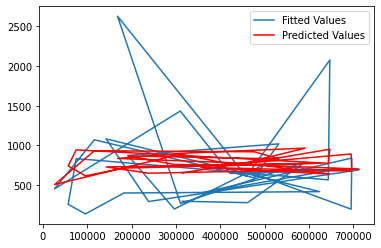

In [42]:
df.loc[(np.abs(stats.zscore(df['trip_duration'])) >= 3), 'trip_duration'] = df[(np.abs(stats.zscore(df['trip_duration'])) < 3)]['trip_duration'].max()
X = df.drop('trip_duration', axis = 1)
Y = df['trip_duration']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
Y_predicted = reg.predict(X_test)

residuals = pd.DataFrame({
    'fitted_values': Y_test,
    'predicted_values': Y_predicted
})
plt.plot(residuals['fitted_values'][:30], label='Fitted Values')
plt.plot(residuals['predicted_values'][:30], label='Predicted Values', color = 'r')
plt.legend()

In [43]:
coeffs = create_lr_model(X, Y)

Training MAE is 464.12576039236825
Testing MAE is 463.5641904007987


This is a significant achievement in terms of reducing MAE, from our previous model. We would save the frame and would proceed in further optimization process.

In [44]:
df_toSave = df.copy()
df_toSave.to_csv('taxi-trip-capping-target.csv', index = False)

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, preprocessing

df = pd.read_csv('taxi-trip-capping-target.csv')
df.head()

,store_and_fwd_flag_Y,store_and_fwd_flag_N,dropoff_day_Monday,dropoff_day_Sunday,dropoff_day_Tuesday,dropoff_day_Saturday,dropoff_day_Wednesday,dropoff_day_Friday,dropoff_day_Thursday,pickup_longitude,vendor_id,passenger_count,pickup_time,pickup_date,pickup_latitude,pickup_month_January,pickup_month_February,pickup_month_March,trip_duration
0,0,1,1,0,0,0,0,0,0,-73.953918,2,1,16,29,40.778873,0,1,0,400
1,0,1,0,0,0,1,0,0,0,-73.988312,1,2,23,11,40.731743,0,0,1,1100
2,0,1,0,1,0,0,0,0,0,-73.997314,2,2,18,21,40.721458,0,1,0,1635
3,0,1,0,0,1,0,0,0,0,-73.961670,2,6,9,5,40.759720,1,0,0,1141
4,0,1,0,0,0,0,1,0,0,-74.017120,1,1,6,17,40.708469,0,1,0,848


#### Optimized Model with scaled features - 

In [13]:
X = df.drop('trip_duration', axis = 1)
Y = df['trip_duration']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
reg = LinearRegression(normalize=True).fit(X_train, Y_train)

Y_predicted = reg.predict(X_train)
mae = metrics.mean_absolute_error(Y_train, Y_predicted)

print('Training MAE is {}'.format(mae))

Y_predicted = reg.predict(X_test)
mae = metrics.mean_absolute_error(Y_test, Y_predicted)

print('Testing MAE is {}'.format(mae))

Training MAE is 464.12865195346444
Testing MAE is 463.56710019752853


Feeding model with scaled features didn't optimize the performance any further. We tried this because, latitude and longitude columns had visibly starting and stop points compared to other columns. We would now apply few other optimization teniques and see how the model performance varies per that.

In [18]:
Y_test.shape, Y_predicted.shape

((145865,), (145865,))

#### Analysing residuals - 

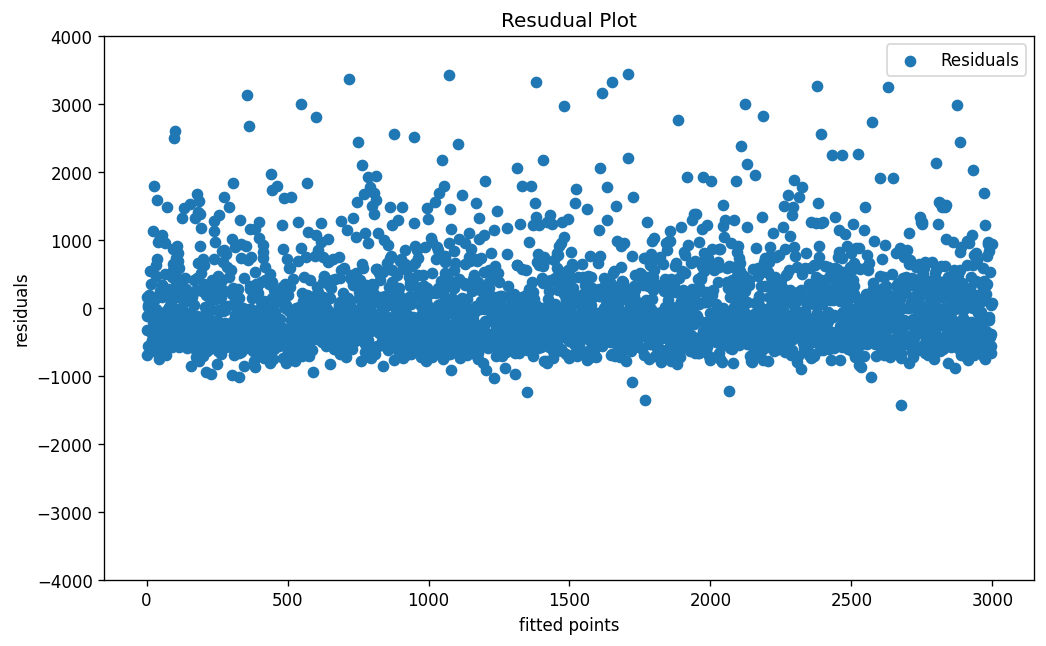

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

residuals = pd.DataFrame({
    'fitted_values': Y_test,
    'predicted_values': Y_predicted
})
residuals['residuals'] = residuals['fitted_values'] - residuals['predicted_values']

plt.figure(figsize = (10, 6), dpi = 120, facecolor = 'w', edgecolor = 'b')
f = range(0, 3000)
k = (0 for i in range (0, 3000))
plt.scatter(f, residuals.residuals[:3000], label = 'Residuals')
#plt.plot(f, k, color = 'red', label = 'regression line')
plt.xlabel('fitted points')
plt.ylabel('residuals')
plt.title('Resudual Plot')
plt.ylim(-4000, 4000)
plt.legend()

Text(0.5, 1.0, 'Distribution of Error Terms')

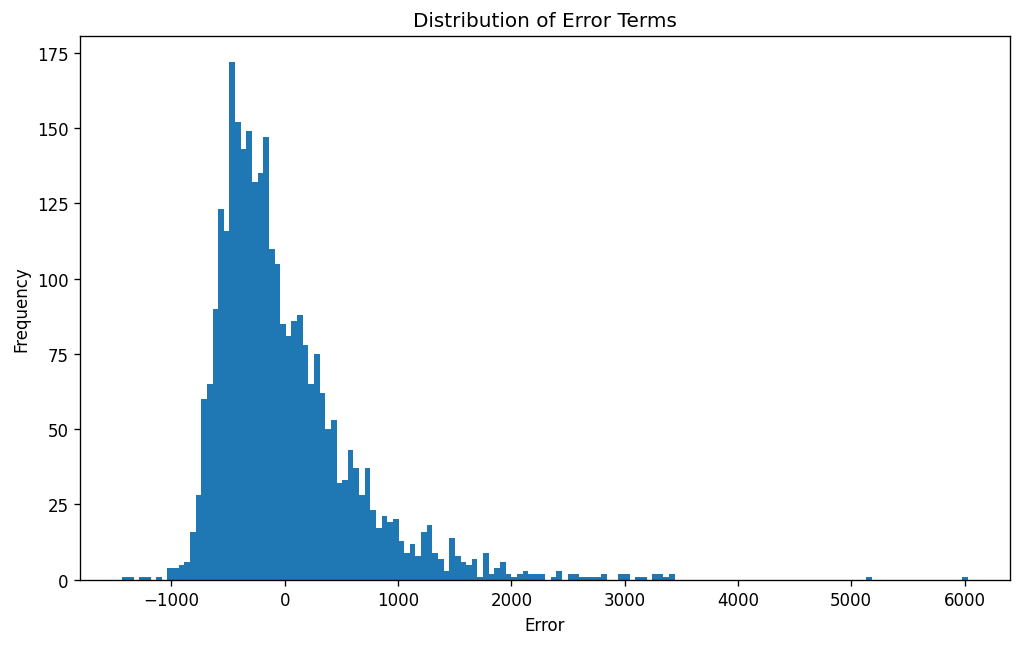

In [22]:
plt.figure(figsize = (10, 6), dpi = 120, facecolor = 'w', edgecolor = 'b')
plt.hist(residuals.residuals[:3000], bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')

Text(0.5, 1.0, 'Checking distribution of Residual Errors')

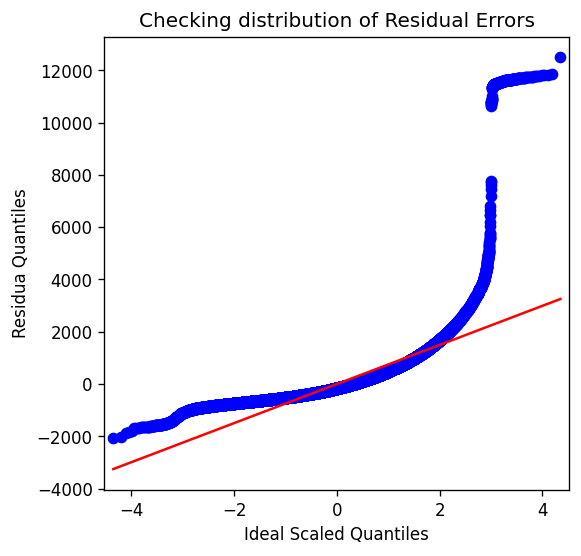

In [24]:
from statsmodels.graphics.gofplots import qqplot
fig, ax = plt.subplots(figsize = (5, 5), dpi = 120)
qqplot(residuals.residuals, line = 's', ax = ax)
plt.ylabel('Residua Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')

In the three plots above, we analyzed the residuals from our last model. We saw that, residuals do not share a fixed pattern, or we cannot guess a residual from its predecessor. Also, residuals follow more or less normal distribution while plotted in histogram, along with frequencies. The right skewness in the graph is indicative of presence of outliers. QQ Plot also shows the presence of outliers.

So, we have build a linear regression model with reasonable accuracy. We have only used the regression models to predict trip duration, a continuous data. Now, as we have quite a lot of records and have number of features on a higher side, along with high variability, we think, a more robust model like decision tree or random forest would be a better predictor (may be with an option of bagging). We can build individual shallow trees with both sub set of records and/or features and consider the weighted mean of the predicted values.

Alternatively, we have seen that quite a number of features are correlated, so probably a more complex model would try to include interaction terms, rather than dropping those fields. But it would make the model more complex and probably more towards overfitting by giving more importance to those individual training features and their interactions. Everything would depend on the business values of the features and when/if we would not be able to eliminate them at the cost of complexity.